In [13]:
%matplotlib qt

ModuleNotFoundError: No module named 'ipympl'

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import scipy.signal
import mne
import pandas as pd
import joblib
import xarray as xr

from n0_config_params import *
from n0bis_config_analysis_functions import *

In [3]:
################################
######## LOAD DATA ########
################################

#sujet, session_i = 'PD01', 1
def open_raw_data_session(sujet, session_i):

    #### open raw and adjust for sujet
    os.chdir(os.path.join(path_data, 'eeg'))

    sujet_eeg_open = sujet[-2:] + sujet[:-2]

    if sujet_eeg_open == 'NT28' and session_i == 0:

        raw = mne.io.read_raw_brainvision(f'{sujet_eeg_open}_ses0{session_i+2}.vhdr', preload=True)
        raw_2 = mne.io.read_raw_brainvision(f'{sujet_eeg_open}_ses0{session_i+2}_2.vhdr', preload=True)

        raw = mne.concatenate_raws([raw, raw_2])

    elif sujet_eeg_open == 'AR30' and session_i == 2:

        raw = mne.io.read_raw_brainvision(f'{sujet_eeg_open}_ses0{session_i+2}.vhdr', preload=True)
        srate = int(raw.info['sfreq'])
        raw.crop(tmin=1076000/srate, tmax=None)

    else:

        raw = mne.io.read_raw_brainvision(f'{sujet_eeg_open}_ses0{session_i+2}.vhdr', preload=True)

    srate = int(raw.info['sfreq'])

    if srate != 500:
        raise ValueError(f'#### WARNING : {sujet_eeg_open} srate != 500 ####')

    #### Data vizualisation
    if debug == True :
        duration = 4.
        n_chan = 20
        raw.plot(scalings='auto',duration=duration,n_channels=n_chan)# verify

    #raw.info['ch_names'] # verify

    #### identify EOG and rename chans
    # raw[raw.info['ch_names'].index('36'), :] = raw.get_data()[raw.info['ch_names'].index('Fp1'), :]
    # mne.rename_channels(raw.info, {'36' : 'VEOG'})

    if debug:
        data_plot = raw[raw.info['ch_names'].index('Fp1'), :][0][0,:int(1e10)]
        plt.plot(data_plot)
        plt.show()
    
    #### select raw_eeg
    raw_eeg = raw.copy()
    drop_chan = ['PRESS','ECG','TRIG']
    raw_eeg.info['ch_names']
    raw_eeg.drop_channels(drop_chan)

    #### select aux chan
    raw_aux = raw.copy()
    select_chan = ['PRESS','ECG','TRIG']
    raw_aux = raw_aux.pick_channels(select_chan)

    if debug:
        plt.plot(zscore(raw_aux.get_data()[0,:]), label='PRESS')
        plt.plot(zscore(raw_aux.get_data()[1,:]), label='ECG')
        plt.plot(zscore(raw_aux.get_data()[2,:]), label='TRIG')
        plt.legend()
        plt.show()

    #### remove trig
    raw_aux.drop_channels(['TRIG'])

    #raw_eeg.info # verify
    #raw_aux.info # verify
    
    del raw

    return raw_eeg, raw_aux









########################
######## VIEWER ########
########################



def viewer(sujet, cond, odor, chan_selection, filter=False, raw=False):

    #### params
    chan_list_i = [chan_i for chan_i, chan in enumerate(chan_list) if chan in chan_selection]
    chan_list_i.insert(0, chan_list.index('PRESS'))
    chan_list_i.insert(0, chan_list.index('ECG'))

    session_i = list(odor_order[sujet].values()).index(odor)

    #### load data
    print('load')
    if raw:
        raw_eeg, raw_aux = open_raw_data_session(sujet, session_i)
        data = np.concatenate((raw_eeg.get_data(), raw_aux.get_data()), axis=0)[chan_list_i,:]
    else:
        data = load_data_sujet(sujet, cond, odor)[chan_list_i,:]

    trig = pd.read_excel(os.path.join(path_prep, sujet, 'info', f"{sujet}_{session_i}_trig.xlsx")).drop(columns=['Unnamed: 0'])

    chan_labels = ['ecg', 'respi']
    chan_labels.extend([f"{chan}" for chan_i, chan in enumerate(chan_selection)])

    if debug:

        plt.plot(data[0,:])
        plt.show()

        respfeatures = load_respfeatures(sujet)[cond][odor]

        _x = zscore(data[-1,:])
        _respi = zscore(data[1,:])+5

        s = 100
        plt.plot(_respi, color='k', zorder=0)
        plt.plot(_x, zorder=0)
        plt.scatter(respfeatures['inspi_index'], _respi[respfeatures['inspi_index']], color='g', label='inspi', s=s, zorder=1)
        plt.scatter(respfeatures['expi_index'], _respi[respfeatures['expi_index']], color='b', label='expi', s=s, zorder=1)
        plt.scatter(respfeatures['inspi_index'], _x[respfeatures['inspi_index']], color='g', label='inspi', s=s, zorder=1)
        plt.scatter(respfeatures['expi_index'], _x[respfeatures['expi_index']], color='b', label='expi', s=s, zorder=1)
        plt.legend()
        plt.show()

    #### downsample
    print('resample')
    srate_downsample = 50

    time_vec = np.linspace(0,data.shape[-1],data.shape[-1])/srate
    time_vec_resample = np.linspace(0,data.shape[-1],int(data.shape[-1] * (srate_downsample / srate)))/srate

    data_resampled = np.zeros((data.shape[0], time_vec_resample.shape[0]))

    for chan_i in range(data.shape[0]):
        f = scipy.interpolate.interp1d(time_vec, data[chan_i,:], kind='quadratic', fill_value="extrapolate")
        data_resampled[chan_i,:] = f(time_vec_resample)

    trig_data = {'start' : [], 'stop' : []}
    for cond_i in conditions:
        _start = [i for i in trig.query(f"name == '{cond_i}'")['time'].values[0][1:-1].split(' ') if len(i) != 0]
        _start = int(_start[0])/srate
        _stop = [i for i in trig.query(f"name == '{cond_i}'")['time'].values[0][1:-1].split(' ') if len(i) != 0]
        _stop = int(_stop[1])/srate
        trig_data['start'].append(_start)
        trig_data['stop'].append(_stop)
    trig = pd.DataFrame(trig_data)

    if debug:

        plt.plot(time_vec, data[chan_i,:], label='raw')
        plt.plot(time_vec_resample, data_resampled[chan_i,:], label='resampled')
        plt.legend()
        plt.show()

    #### for one chan
    print('plot')
    if len(chan_selection) == 1:

        x = data_resampled[-1,:]

        respi = data_resampled[1,:]
        ecg = data_resampled[0,:]*-1

        if filter:

            fcutoff = 40
            transw  = .2
            order   = np.round( 7*srate/fcutoff )
            shape   = [ 0,0,1,1 ]
            frex    = [ 0, fcutoff, fcutoff+fcutoff*transw, srate/2 ]
            filtkern = scipy.signal.firls(order+1,frex,shape,fs=srate)
            x = scipy.signal.filtfilt(filtkern,1,x)


            fcutoff = 100
            transw  = .2
            order   = np.round( 7*srate/fcutoff )
            shape   = [ 1,1,0,0 ]
            frex    = [ 0, fcutoff, fcutoff+fcutoff*transw, srate/2 ]
            filtkern = scipy.signal.firls(order,frex,shape,fs=srate)
            x = scipy.signal.filtfilt(filtkern,1,x)

        chan_i = 0

        fig, ax = plt.subplots()
        
        ax.plot(time_vec_resample, zscore(ecg), label=chan_labels[0])
        ax.plot(time_vec_resample, zscore(respi)+3, label=chan_labels[1])
    
        ax.plot(time_vec_resample, zscore(x)+3*(chan_i+2), label=chan_labels[chan_i+2])

        ax.vlines(trig['start'].values, ymin=zscore(respi).min(), ymax=(zscore(x)+3*(chan_i+2)).max(), colors='g', label='start')
        ax.vlines(trig['stop'].values, ymin=zscore(respi).min(), ymax=(zscore(x)+3*(chan_i+2)).max(), colors='r', label='stop')
        
        ax.set_title(f"{sujet} {cond} {odor} raw:{raw}")
        plt.legend()
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(reversed(handles), reversed(labels), loc='upper left')  # reverse to keep order consistent

        plt.show()

    #### for several chan
    else:

        chan_list_data_resampled = np.arange(data_resampled.shape[0])

        respi = data_resampled[1,:]
        ecg = data_resampled[0,:]

        fig, ax = plt.subplots()

        ax.plot(time_vec_resample, zscore(ecg), label=chan_labels[0])
        ax.plot(time_vec_resample, zscore(respi)+3, label=chan_labels[1])

        for chan_count, chan_i in enumerate(chan_list_data_resampled[2:]):
        
            x = data_resampled[chan_i,:]
            
            if filter:

                fcutoff = 40
                transw  = .2
                order   = np.round( 7*srate/fcutoff )
                shape   = [ 0,0,1,1 ]
                frex    = [ 0, fcutoff, fcutoff+fcutoff*transw, srate/2 ]
                filtkern = scipy.signal.firls(order+1,frex,shape,fs=srate)
                x = scipy.signal.filtfilt(filtkern,1,x)


                fcutoff = 100
                transw  = .2
                order   = np.round( 7*srate/fcutoff )
                shape   = [ 1,1,0,0 ]
                frex    = [ 0, fcutoff, fcutoff+fcutoff*transw, srate/2 ]
                filtkern = scipy.signal.firls(order,frex,shape,fs=srate)
                x = scipy.signal.filtfilt(filtkern,1,x)

            ax.plot(time_vec_resample, zscore(x)+3*(chan_count+2), label=chan_labels[chan_i])

        ax.vlines(trig['start'].values, ymin=zscore(respi).min(), ymax=(zscore(x)+3*(chan_count+2)).max(), colors='g', label='start')
        ax.vlines(trig['stop'].values, ymin=zscore(respi).min(), ymax=(zscore(x)+3*(chan_count+2)).max(), colors='r', label='stop')
        
        ax.set_title(f"{sujet} {cond} {odor} raw:{raw}")
        plt.legend()
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(reversed(handles), reversed(labels), loc='upper left')  # reverse to keep order consistent

        plt.show()

    return fig






load
resample
plot


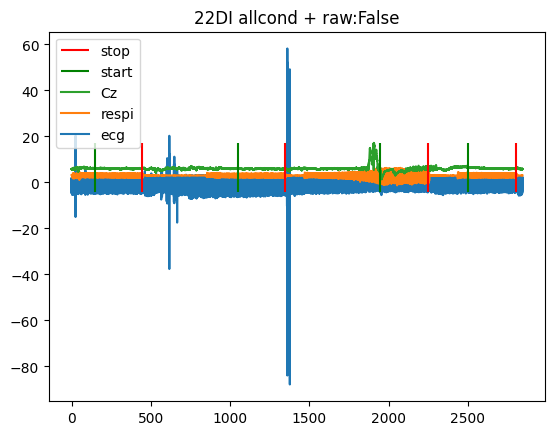

In [10]:

################################
######## EXECUTE ########
################################


sujet_list = ['01PD','02MJ','03VN','04GB','05LV','06EF','07PB','08DM','09TA','10BH','11FA','12BD','13FP',
'14MD','15LG','16GM','17JR','18SE','19TM','20TY','21ZV','22DI','23LF','24TJ','25DF','26MN','27BD','28NT','29SC',
'30AR','31HJ','32CM','33MA']

sujet = '22DI'

cond = 'allcond'

#     cond = 'FR_CV_1'
#     cond = 'MECA'
#     cond = 'CO2'
#     cond = 'FR_CV_2'

#     odor = 'o'
odor = '+'
#     odor = '-'

# chan_list = ['Fp1', 'Fz', 'F3', 'F7', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'TP9', 'CP5', 'CP1', 'Pz', 'P3', 'P7', 'O1', 
#         'Oz', 'O2', 'P4', 'P8', 'TP10', 'CP6', 'CP2', 'Cz', 'C4', 'T8', 'FT10', 'FC6', 'FC2', 'F4', 'F8', 'Fp2', 
#         'PRESS', 'ECG', 'ECG_cR']

# chan_selection = ['Fp1', 'Fz', 'F3', 'F7', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'TP9', 'CP5', 'CP1', 'Pz', 'P3', 'P7', 'O1']
# chan_selection = ['Oz', 'O2', 'P4', 'P8', 'TP10', 'CP6', 'CP2', 'Cz', 'C4', 'T8', 'FT10', 'FC6', 'FC2', 'F4', 'F8', 'Fp2']

chan_selection = ['Cz']

# fig = viewer(sujet, cond, odor, chan_selection, filter=False, raw=True)
viewer(sujet, cond, odor, chan_selection, filter=False, raw=False)
